In [11]:
%matplotlib inline
import os

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from pyspark.context import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.session import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import array, col, count, mean, sum, udf, when
from pyspark.sql.types import DoubleType, IntegerType, StringType, Row
from pyspark.sql.functions import sum, col, udf

import warnings
warnings.filterwarnings("ignore")

sns.set_style("white")
sns.set_color_codes()

In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 9
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.titlesize'] = 18

display(HTML('<style>.container {width:80% !important;}</style>'))
update_title = 'document.title = "Using Python, Hadoop and Apache Spark to Analyze the NBA and the 3-point Shot";'
HTML('<script>{}</script>'.format(update_title))

In [18]:
# sc = SparkContext('local')
spark = SparkSession(sc)
sqlContext = SQLContext(sc)

In [6]:
df = spark.read.option('header','true')\
          .option('inferSchema','true')\
          .csv('hdfs://localhost:9000/basketball/data/season_totals.csv')

In [7]:
df.cache()

22/10/05 14:52:39 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


DataFrame[_c0: int, player: string, pos: string, age: int, team_id: string, g: int, gs: int, mp: int, fg: int, fga: int, fg_pct: double, fg3: int, fg3a: int, fg3_pct: double, fg2: int, fg2a: int, fg2_pct: double, efg_pct: double, ft: int, fta: int, ft_pct: double, orb: int, drb: int, trb: int, ast: int, stl: int, blk: int, tov: int, pf: int, pts: int, yr: int]

In [8]:
df.orderBy('pts',ascending = False).limit(10).toPandas()[['yr','player','age','pts','fg3']]

22/10/05 14:53:39 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , player, pos, age, team_id, g, gs, mp, fg, fga, fg_pct, fg3, fg3a, fg3_pct, fg2, fg2a, fg2_pct, efg_pct, ft, fta, ft_pct, orb, drb, trb, ast, stl, blk, tov, pf, pts, yr
 Schema: _c0, player, pos, age, team_id, g, gs, mp, fg, fga, fg_pct, fg3, fg3a, fg3_pct, fg2, fg2a, fg2_pct, efg_pct, ft, fta, ft_pct, orb, drb, trb, ast, stl, blk, tov, pf, pts, yr
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/basketball/data/season_totals.csv


,yr,player,age,pts,fg3
0,1987,"Jordan,Michael",23,3041,12
1,1988,"Jordan,Michael",24,2868,7
2,2006,"Bryant,Kobe",27,2832,180
3,2019,"Harden,James",29,2818,378
4,1990,"Jordan,Michael",26,2753,92
5,1989,"Jordan,Michael",25,2633,27
6,2014,"Durant,Kevin",25,2593,192
7,1980,"Gervin,George",27,2585,32
8,1991,"Jordan,Michael",27,2580,29
9,2017,"Westbrook,Russell",28,2558,200


In [9]:
print(df.columns)

['_c0', 'player', 'pos', 'age', 'team_id', 'g', 'gs', 'mp', 'fg', 'fga', 'fg_pct', 'fg3', 'fg3a', 'fg3_pct', 'fg2', 'fg2a', 'fg2_pct', 'efg_pct', 'ft', 'fta', 'ft_pct', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'yr']


In [19]:
sqlContext.registerDataFrameAsTable(df, 'df')
fga_py = sqlContext.sql('''SELECT yr,sum(fg3a)/sum(mp)*36 fg3a_p36m FROM df GROUP BY yr ORDER BY yr''')

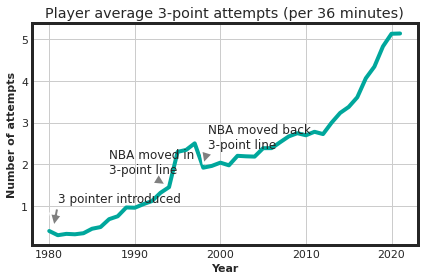

In [38]:
_df = fga_py.toPandas()
plt.plot(_df.yr,_df.fg3a_p36m, color = '#00a79c')
plt.xlabel('Year')
plt.ylabel('Number of attempts')
_=plt.title('Player average 3-point attempts (per 36 minutes)')
_=plt.annotate('3 pointer introduced', xy=(1980.5, .5), xytext=(1981, 1.1), fontsize = 12,
               arrowprops=dict(facecolor='grey', shrink=0.05, linewidth = 2))
_=plt.annotate('NBA moved in\n3-point line', xy=(1993.7, 1.5), xytext=(1987, 1.79), fontsize = 12,
               arrowprops=dict(facecolor='grey', shrink=0.05, linewidth = 2))
_=plt.annotate('NBA moved back\n3-point line', xy=(1998, 2.), xytext=(1998.5, 2.4), fontsize = 12,
               arrowprops=dict(facecolor='grey', shrink=0.05, linewidth = 2))
plt.tight_layout()
plt.grid()
plt.savefig('results/3_point_trend.png')

In [39]:
t = VectorAssembler(inputCols=['yr'], outputCol = 'features')

training = t.transform(fga_py)\
            .withColumn('yr',fga_py.yr)\
            .withColumn('label',fga_py.fg3a_p36m)

training.toPandas().head()

,yr,fg3a_p36m,features,label
0,1980,0.410089,[1980.0],0.410089
1,1981,0.309376,[1981.0],0.309376
2,1982,0.341511,[1982.0],0.341511
3,1983,0.331479,[1983.0],0.331479
4,1984,0.357110,[1984.0],0.357110


In [40]:
lr = LinearRegression(maxIter=10)
model = lr.fit(training)

22/10/05 15:18:27 WARN Instrumentation: [d8e594d5] regParam is zero, which might cause numerical instability and overfitting.


In [41]:
training_yrs = training.select('yr').rdd.map(lambda x: x[0]).collect()
training_y = training.select('fg3a_p36m').rdd.map(lambda x: x[0]).collect()
prediction_yrs = [2022, 2023, 2024, 2025, 2026]
all_yrs = training_yrs + prediction_yrs

test_rdd = sc.parallelize(all_yrs)
row = Row('yr')
all_years_features = t.transform(test_rdd.map(row).toDF())

df_results = model.transform(all_years_features).toPandas()

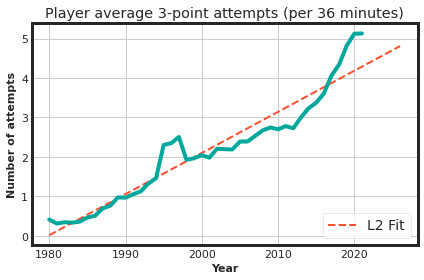

In [42]:
plt.plot(df_results.yr,df_results.prediction, linewidth = 2, linestyle = '--',color = '#fc4f30', label = 'L2 Fit')
plt.plot(training_yrs, training_y, color = '#00a79c', label = None)
plt.xlabel('Year')
plt.ylabel('Number of attempts')
plt.legend(loc = 4)
_=plt.title('Player average 3-point attempts (per 36 minutes)')
plt.tight_layout()
plt.grid()
plt.savefig('results/model_prediction.png')